In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # [-1,1]
])

# Download CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [4]:
def image_transforms(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    ])

    return reverse_transforms(image)

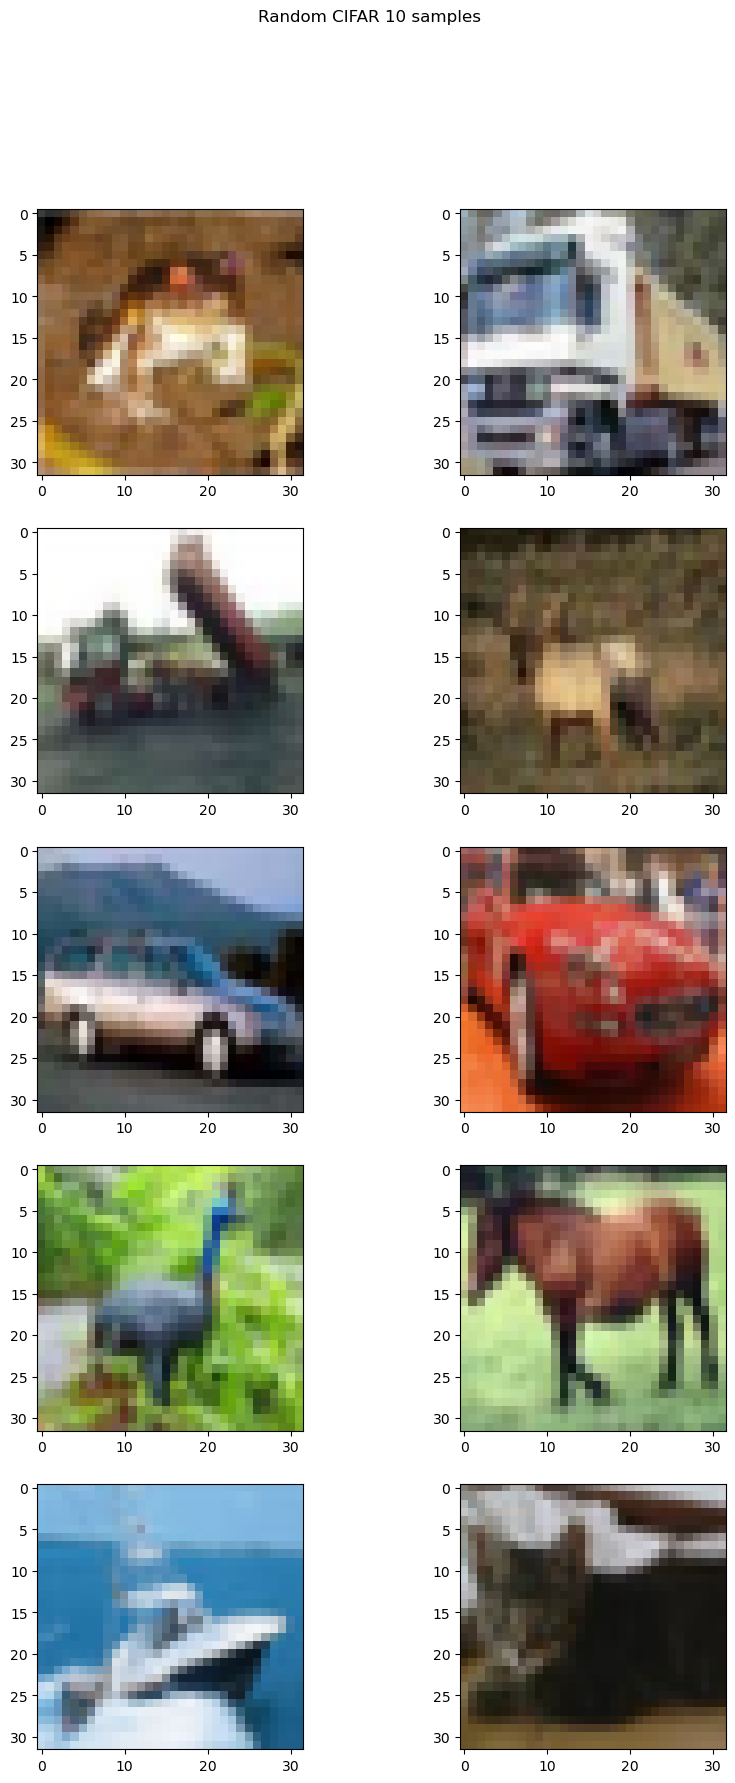

In [10]:
img = 0
fig, axs = plt.subplots(5,2,figsize = (10,20))
for data, labels in train_dataset:
    axs[int(img/2),img%2].imshow(image_transforms(data))
    img += 1
    if(img == 10):
        break
fig.suptitle("Random CIFAR 10 samples")
plt.show()

In [11]:
class DiffusionSampler:
    def __init__(self, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
        self.sqrt_alphas_cumprod = sqrt_alphas_cumprod
        self.sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod
        self.device = device

    def get_index_from_list(self, vals, t, x_shape):
        out = vals.index_select(-1, t)
        return out.reshape(t.shape[0], *((1,) * (len(x_shape) - 1))).to(self.device)

    def forward_diffusion(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        return (
            sqrt_alphas_cumprod_t.to(self.device) * x_0.to(self.device) +
            sqrt_one_minus_alphas_cumprod_t.to(self.device) * noise.to(self.device),
            noise.to(self.device)
        )


In [12]:
T = 300
b1 = 0.00001
b2 = 0.02
betas = torch.linspace(b1, b2, T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
noising = DiffusionSampler(sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod, device)

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_52829/2587627223.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the vali

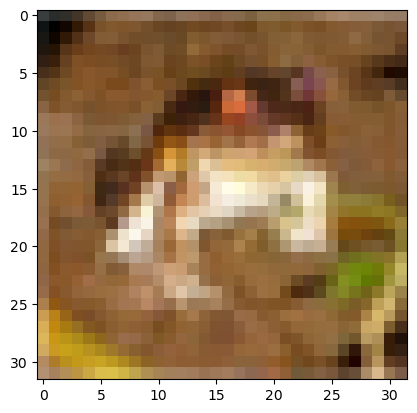

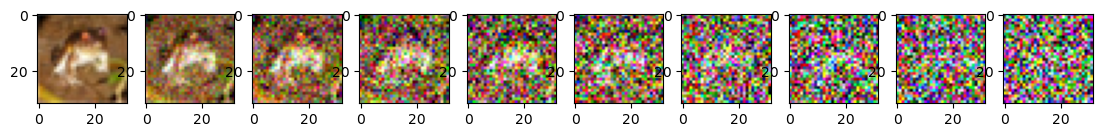

In [13]:
# Simulate forward diffusion
image = train_dataset[0][0]
plt.imshow(image_transforms(image))

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = noising.forward_diffusion(image, t)
    plt.imshow(image_transforms(img).cpu())

In [15]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super(Block, self).__init__()

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1) if up else nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1) if up else nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t)).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len = 32):
        super().__init__()
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model) # 1000^(2i/d_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding):
        # Residual connection + pos encoding
        return (token_embedding + self.pos_encoding[:token_embedding.size(1), :])


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            PositionalEncoding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(3, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim)
            for i in range(len(down_channels)-1)
        ])

        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            for i in range(len(up_channels)-1)
        ])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [20]:
@torch.no_grad()
def sample_timestep(x, t, model):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = noising.get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = noising.get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = noising.get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = noising.get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model):
    # Sample noise
    img_size = 32
    img = torch.randn((10, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, model)
        img = torch.clamp(img, -1.0, 1.0)
    return img   

In [27]:
model = Unet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 15
losses = []
criterion = nn.MSELoss()

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
      optimizer.zero_grad()
      t = torch.randint(0, T, (len(images),), device=device).long()
      x_noisy, noise = noising.forward_diffusion(images, t)
      noise_pred = model(x_noisy, t)
      loss = criterion(noise_pred, noise)
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch}  Loss: {loss.item()} ")
      running_loss += loss.item()
    losses.append(running_loss / len(train_loader))

Epoch 0  Loss: 1.027156114578247 
Epoch 0  Loss: 0.9568911790847778 
Epoch 0  Loss: 0.8839708566665649 
Epoch 0  Loss: 0.8267965316772461 
Epoch 0  Loss: 0.7887406349182129 
Epoch 0  Loss: 0.72373366355896 
Epoch 0  Loss: 0.6878980398178101 
Epoch 0  Loss: 0.6517390012741089 
Epoch 0  Loss: 0.6124110817909241 
Epoch 0  Loss: 0.5803920030593872 
Epoch 0  Loss: 0.5211803317070007 
Epoch 0  Loss: 0.515234112739563 
Epoch 0  Loss: 0.49383795261383057 
Epoch 0  Loss: 0.4907400608062744 
Epoch 0  Loss: 0.45064911246299744 
Epoch 0  Loss: 0.4450366497039795 
Epoch 0  Loss: 0.4222871661186218 
Epoch 0  Loss: 0.43324095010757446 
Epoch 0  Loss: 0.42329031229019165 
Epoch 0  Loss: 0.42281433939933777 
Epoch 0  Loss: 0.4014212489128113 
Epoch 0  Loss: 0.379638671875 
Epoch 0  Loss: 0.40053731203079224 
Epoch 0  Loss: 0.38731464743614197 
Epoch 0  Loss: 0.40000057220458984 
Epoch 0  Loss: 0.36231058835983276 
Epoch 0  Loss: 0.3725111484527588 
Epoch 0  Loss: 0.3514803349971771 
Epoch 0  Loss: 0.38

KeyboardInterrupt: 

In [32]:
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
      optimizer.zero_grad()
      t = torch.randint(0, T, (len(images),), device=device).long()
      x_noisy, noise = noising.forward_diffusion(images, t)
      noise_pred = model(x_noisy, t)
      loss = criterion(noise_pred, noise)
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch}  Loss: {loss.item()} ")
      running_loss += loss.item()
    losses.append(running_loss / len(train_loader))

Epoch 0  Loss: 0.14413884282112122 
Epoch 0  Loss: 0.1698782742023468 
Epoch 0  Loss: 0.17427301406860352 
Epoch 0  Loss: 0.15092486143112183 
Epoch 0  Loss: 0.1303580403327942 
Epoch 0  Loss: 0.14963607490062714 
Epoch 0  Loss: 0.14880779385566711 
Epoch 0  Loss: 0.14436285197734833 
Epoch 0  Loss: 0.14971934258937836 
Epoch 0  Loss: 0.16829350590705872 
Epoch 0  Loss: 0.1514531672000885 
Epoch 0  Loss: 0.15187638998031616 
Epoch 0  Loss: 0.1626032143831253 
Epoch 0  Loss: 0.16114173829555511 
Epoch 0  Loss: 0.1598881185054779 
Epoch 0  Loss: 0.19430522620677948 
Epoch 0  Loss: 0.13728660345077515 
Epoch 0  Loss: 0.15007832646369934 
Epoch 0  Loss: 0.15929695963859558 
Epoch 0  Loss: 0.14184537529945374 
Epoch 0  Loss: 0.15359322726726532 
Epoch 0  Loss: 0.14388936758041382 
Epoch 0  Loss: 0.1560969203710556 
Epoch 0  Loss: 0.14747899770736694 
Epoch 0  Loss: 0.15209168195724487 
Epoch 0  Loss: 0.14201556146144867 
Epoch 0  Loss: 0.15892308950424194 
Epoch 0  Loss: 0.15716895461082458

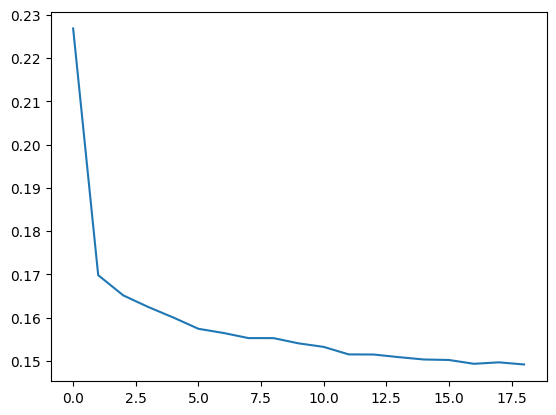

In [35]:
plt.plot(range(19), losses)
plt.show()

In [36]:
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=1, resize=True, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return nn.Softmax(dim = 1)(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

(1.8010347903223007, 0.0)

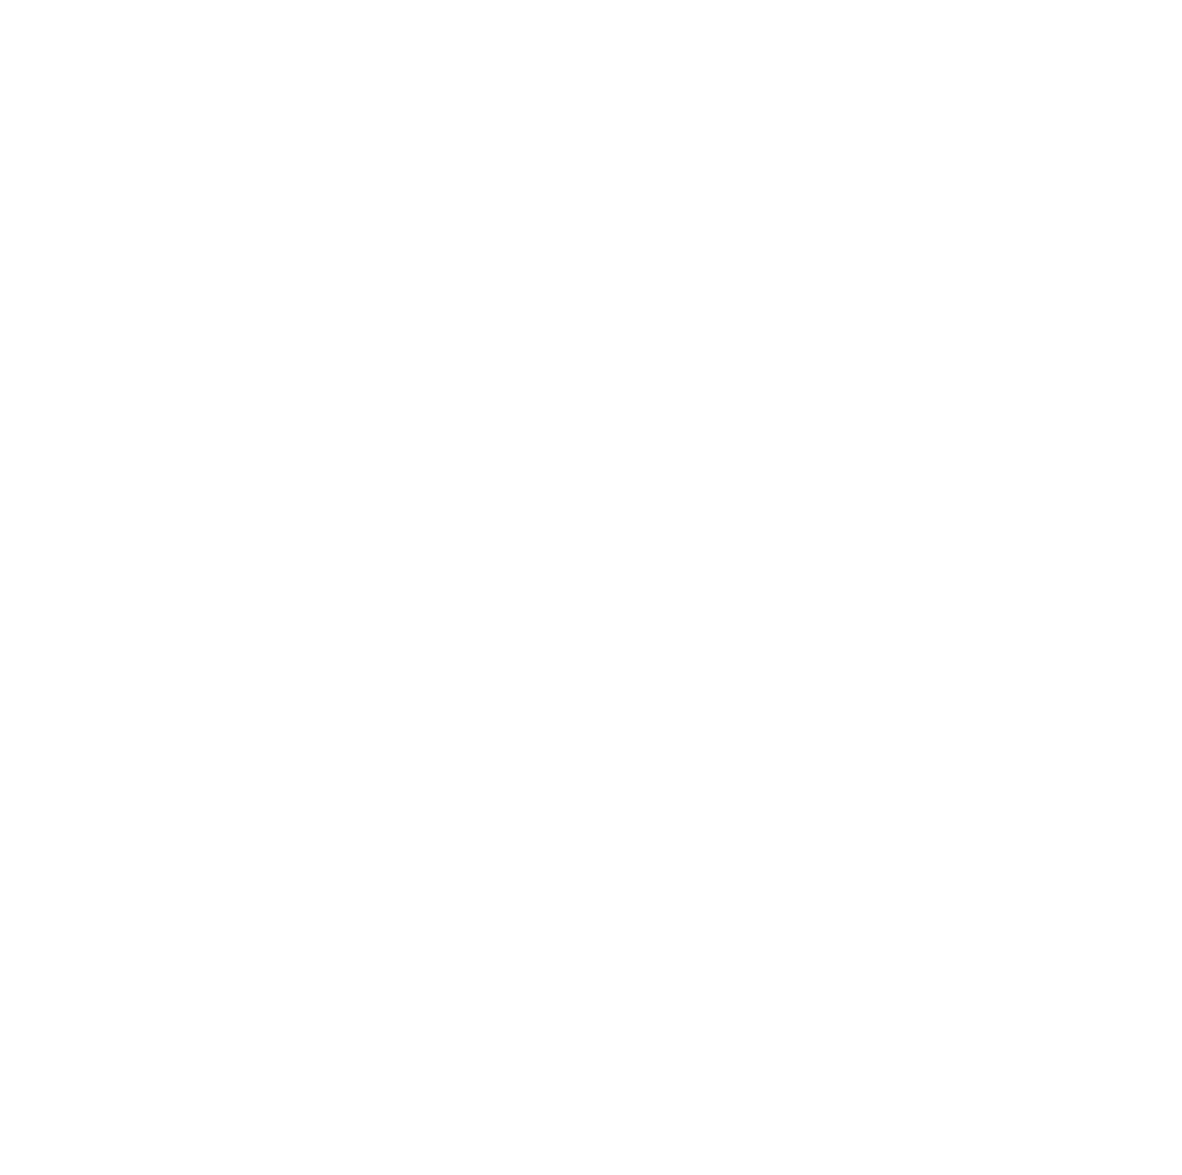

In [37]:
images = sample_plot_image(model)
inception_score(images)

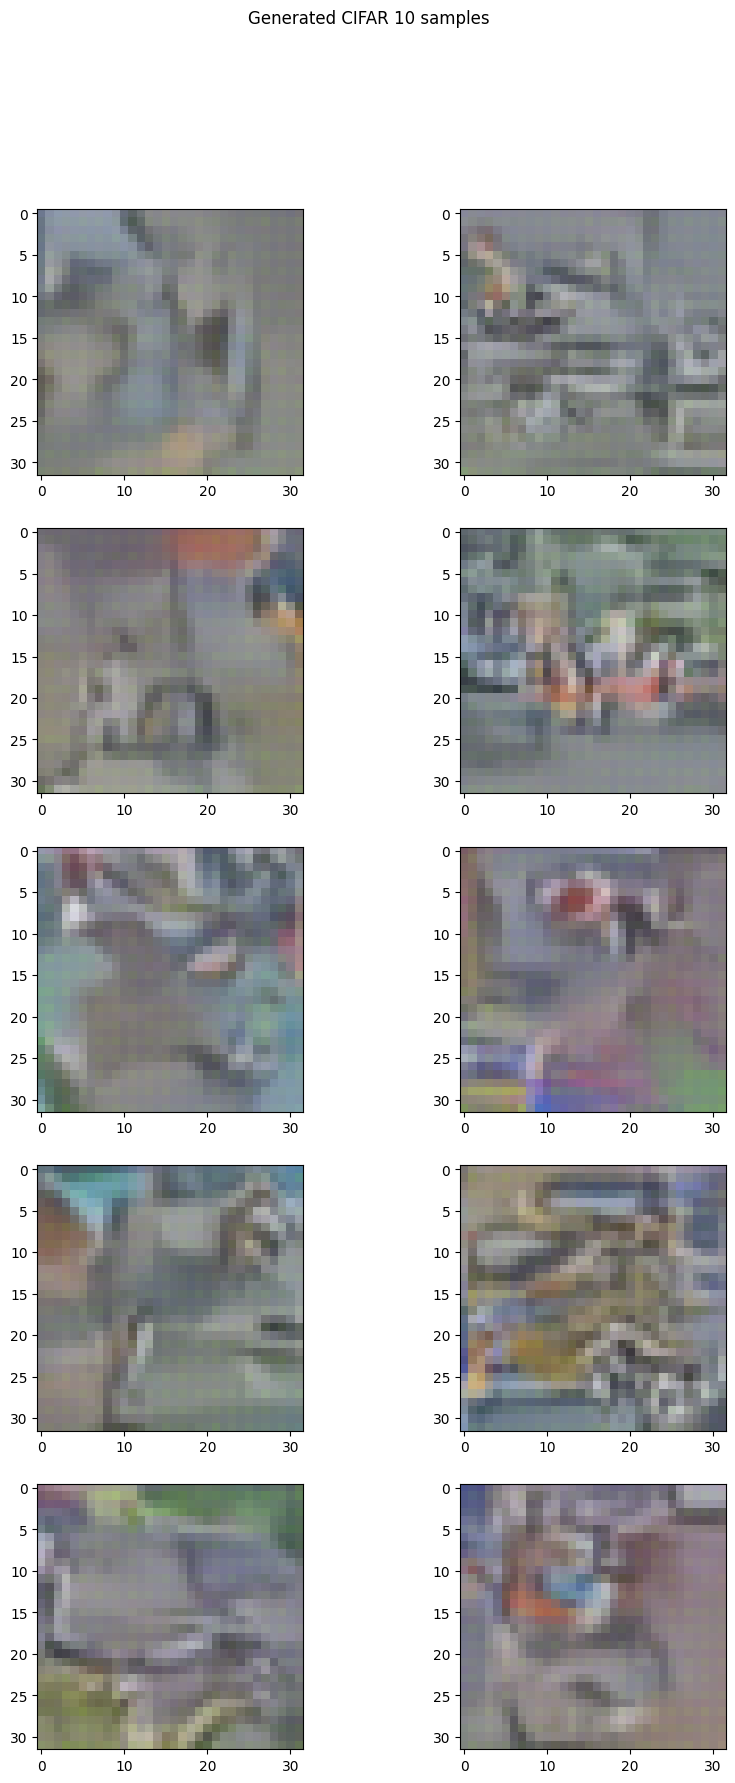

In [38]:
fig, axs = plt.subplots(5,2,figsize = (10,20))
for idx,image in enumerate(images):
    axs[int(idx/2),idx%2].imshow(image_transforms(image.cpu()))
fig.suptitle("Generated CIFAR 10 samples")
plt.show()